# Lab 3 — clustering

In [38]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import json
import operator
import pickle
import random
import math
import matplotlib.pyplot as plt
import numpy as np

from functools import reduce
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool

In [2]:
output_notebook()

%matplotlib inline
plt.style.use("ggplot")

Loading BokehJS ...

## Exercise 3.11

In [3]:
with open("tags_coordinates.pickle", "rb") as f:
    tags_coordinates = pickle.load(f, encoding="utf-8")

tags = list(tags_coordinates.keys())    
X = np.asarray(list(tags_coordinates.values()))

In [4]:
kmeans = [KMeans(n_clusters=i).fit(X) for i in range(2, 6)]

In [5]:
pca = PCA(n_components=2)
pca.fit(X)

t = pca.transform(X)

In [6]:
def get_color(x):
    if x == 0:
        return "#0000FF"
    elif x == 1:
        return "#00FF00"
    elif x == 2:
        return "#FF0000"
    elif x == 3:
        return "#FFFF00"
    else:
        return "#00FFFF"

In [7]:
def plot(i):
    source = ColumnDataSource(
        data={
            "x": t[:, 0],
            "y": t[:, 1],
            "name": tags,
            "color": [get_color(x) for x in kmeans[i].labels_],
        })
    hover = HoverTool(
        tooltips=[
            ("Name", "@name"),
        ])
    tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

    p = figure(plot_width=960, tools=tools)
    p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
    show(p, notebook_handle=True)

In [8]:
plot(0)

In [9]:
plot(1)

In [10]:
plot(2)

In [11]:
plot(3)

## Exercise 3.12

In [12]:
with open("most-rated.pickle", "rb") as f:
    most_rated = pickle.load(f, encoding="utf-8")
    
most_rated_ids = list(map(operator.itemgetter(0), most_rated))

In [13]:
data = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
data = data.filter(lambda x: x.get('movieId') in most_rated_ids)

movies = data.collect()

In [14]:
def jaccard(x, y):
    A = set(x.get('genres'))
    B = set(y.get('genres'))
    n = len(A.intersection(B))
    d = len(A.union(B))
    return n/d

In [30]:
def kmedioids(X, d, k):
    m = [random.choice(X) for _ in range(k)]
    c = [0 for _ in range(len(X))]
    
    delta = math.inf
    delta_prev = 0
    epsilon = len(X) / 100
    
    while delta != delta_prev:
        print("Delta:", delta)
        delta_prev = delta
        delta = 0
        for i, x in enumerate(X):
            dists = [d(x, j) for j in m]
            clus = dists.index(min(dists))
            delta += abs(clus - c[i])
            c[i] = clus
            
        for i in range(k):
            nodes = [j for j, x in enumerate(c) if x == i]            
            dists = []
            for j, x in enumerate(X):
                if c[j] == i:
                    dists.append((sum([d(x, X[y]) for y in nodes])))
                else:
                    dists.append(math.inf)
            m[i] = X[dists.index(min(dists))]
    
    # Returns tuple with mediods and cluster assignements
    return m, c

In [31]:
km = kmedioids(movies, jaccard, 2)

Delta: inf
Delta: 522
Delta: 515
Delta: 29


In [41]:
genres = set(reduce(lambda x, y: x + y, (map(operator.itemgetter('genres'), movies))))

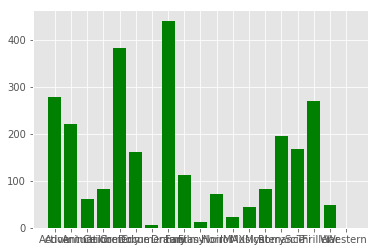

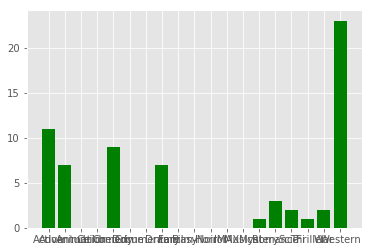

In [55]:
for i in range(len(km[0])):
    freqs = {k: 0 for k in genres}
    nodes = [movies[j].get('genres') for j, x in enumerate(km[1]) if x == i]
    for n in nodes:
        for m in n:
            freqs[m] += 1
    plt.bar(freqs.keys(), freqs.values(), color='g')
    plt.show()